In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import allantools as at

# Section 1 - Steer GPS with CSF data

## 1.1 Define functions needed to steer data

In [2]:
save_dir = '/eos/user/e/elsweene/SWAN_projects/Filtered_data_sets/'

In [3]:
## Load in CSF and GPS data

Zoom_in_CSF = pd.read_csv(save_dir +"Zoom_in_CSF_Data_filtered.csv")
Zoom_in_raw_GPS = pd.read_csv(save_dir + "Zoom_in_Raw_GPS_Data_filtered.csv")

In [4]:
## Assign arrays to columns to allow indexing

Time_GPS_array = np.array(Zoom_in_raw_GPS['Epoch_mjd'])           
offset_array = np.array(Zoom_in_raw_GPS['diff_CLK(ns)'])*1e-9      ## convert to ns

In [5]:
## Assign arrays to columns to allow indexing

Time_CSF_array = np.array(Zoom_in_CSF['TimeStamp'])    
F0_CSF_array = np.array(Zoom_in_CSF['f0']) 

In [6]:
## Define funcction to fit line 

def fit_line(Array_of_interest1,Array_of_interest2,index,numberhrs):
    
    m,b = np.polyfit(Array_of_interest1[index:index+numberhrs],-1*Array_of_interest2[index:index +numberhrs], 1)
    
    return m,b

In [7]:
## Define function with loop to correct data by desired number of hours - in this case need steps to steer GPS data

def CSF_Correction(loop_range,number_hours):

    i = 0
    F0_CSF_array1= np.array(Zoom_in_CSF['f0'])
    steps = []                                   # store steps to steer GPS data later

    for i in loop_range:

        m,b = fit_line(Time_CSF_array,-1*F0_CSF_array1,i,number_hours)     ## fit to section of data 
        step_f = m*(Time_CSF_array[i+(number_hours-1)]) + b                ## calculate step using fit (removes outliers)

        steps.append(step_f)


        F0_CSF_array1[i:] -= step_f             # add step to all frequencies from this index on
        
        
    return F0_CSF_array1,steps

In [8]:
## Define function to steer GPS data w CSF steps

def Steer_GPS_w_CSF(times,step_index,list_steps):   
    
    offset_array1 = np.array(Zoom_in_raw_GPS['diff_CLK(ns)'])*1e-9 

    for n,i in zip(times,step_index) :


        def f(t) :
            return list_steps[i]*t

        cut_gps = Zoom_in_raw_GPS[(Zoom_in_raw_GPS['Epoch_mjd'])>(Time_GPS_array[0]+n)]

        x = np.array(cut_gps['Epoch_mjd'])
        y = f((x-x[0])*86400)

        if i == 0 :

            x_test = x
            y_test = y

        index = len(Time_GPS_array) - len(cut_gps)

        offset_array1[index:] += y

    i+=1       
    n+=1
    
    return offset_array1

In [9]:
def plot_gps_steer(step_hr,steered_array):
    
    plt.figure(figsize=(15,10))
    
    plot1 = plt.scatter(np.array(Zoom_in_raw_GPS['Epoch_mjd']),np.array(Zoom_in_raw_GPS['diff_CLK(ns)']*1e-9),label='Raw')
    plot2 = plt.scatter(Time_GPS_array,np.array(steered_array),label='Shifted after '+ str(step_hr) +' hrs')
    
    plt.title('Plot of Fractional Frequency corrected by step every ' +  str(step_hr) + ' hrs - CSF',fontsize=25)
    plt.xlabel('MJD (days)',fontsize=20)
    plt.ylabel('Fractional Frequency',fontsize=20)

    plt.legend(fontsize=20)
    
    return(plot1,plot2)

In [10]:
## Define function to calculate Allan Deviation and plot

def Allan_Dev_time(y,rate,t,hrs) : 
    
    (t, ad1, ade, adn) = at.oadev(y, rate, data_type="phase",taus=t)
    
    return plt.loglog(t,ad1,'x',label= str(hrs) +' hrs')

## 1.2 Steer GPS data for various CSF steps

(<matplotlib.collections.PathCollection at 0x7f4f04b6ce80>,
 <matplotlib.collections.PathCollection at 0x7f4f04b85310>)

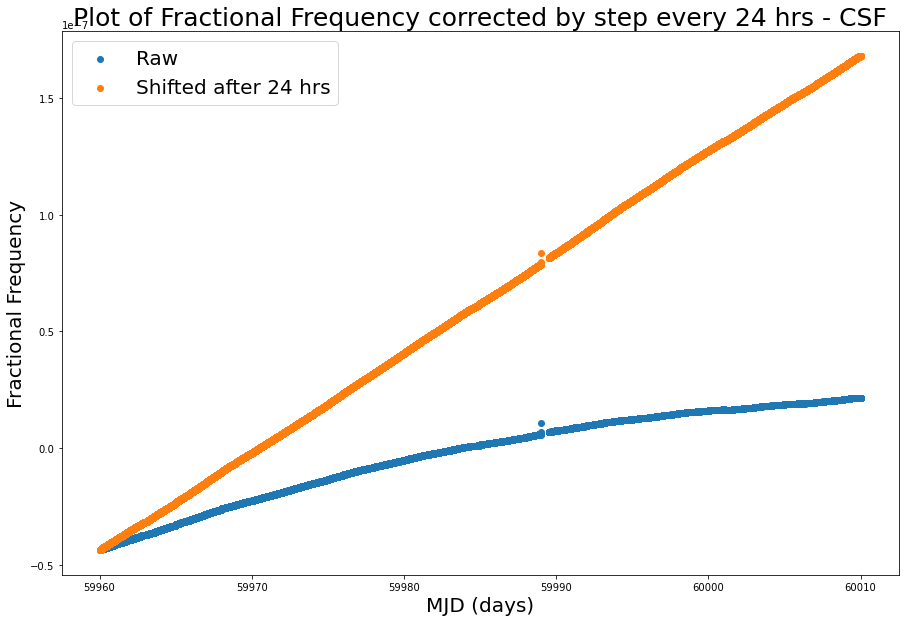

In [11]:
## Steered with 24 hr CSF steps

(F0_CSF_array24,steps24) = (CSF_Correction(np.arange(0,870,24),24))
steer_24hr = Steer_GPS_w_CSF(np.arange(0,50,1),np.arange(0,37,1),steps24)

plot_gps_steer(24,steer_24hr)

(<matplotlib.collections.PathCollection at 0x7f4ef2ba8d30>,
 <matplotlib.collections.PathCollection at 0x7f4ef2bb8190>)

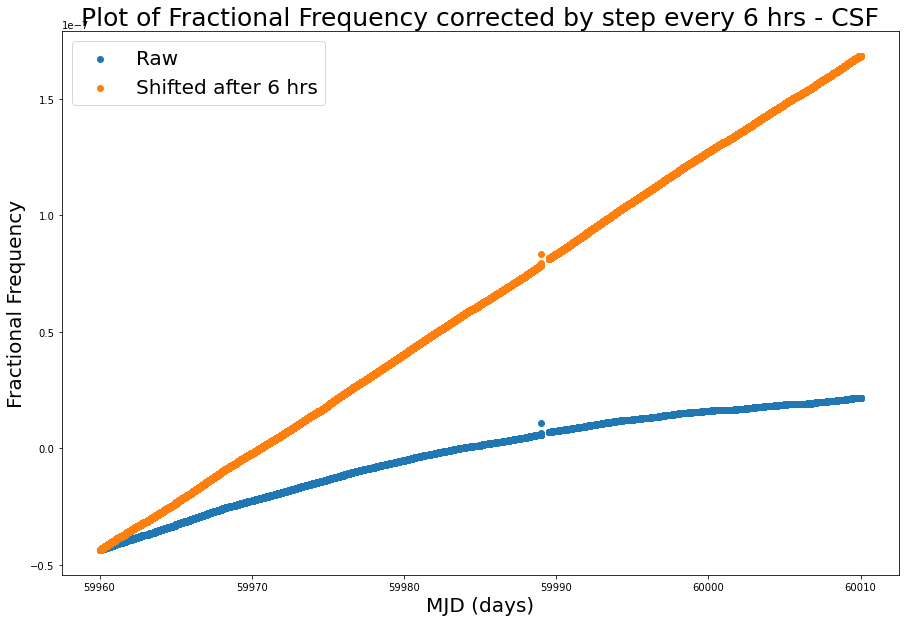

In [12]:
## Steered with 6 hour CSF steps

(F0_CSF_array6,steps6) = (CSF_Correction(np.arange(0,890,6),6))
steer_6hr = Steer_GPS_w_CSF(np.arange(0,50,.25),np.arange(0,149,1),steps6)

plot_gps_steer(6,steer_6hr)

(<matplotlib.collections.PathCollection at 0x7f4ef2dde640>,
 <matplotlib.collections.PathCollection at 0x7f4ef2ddea90>)

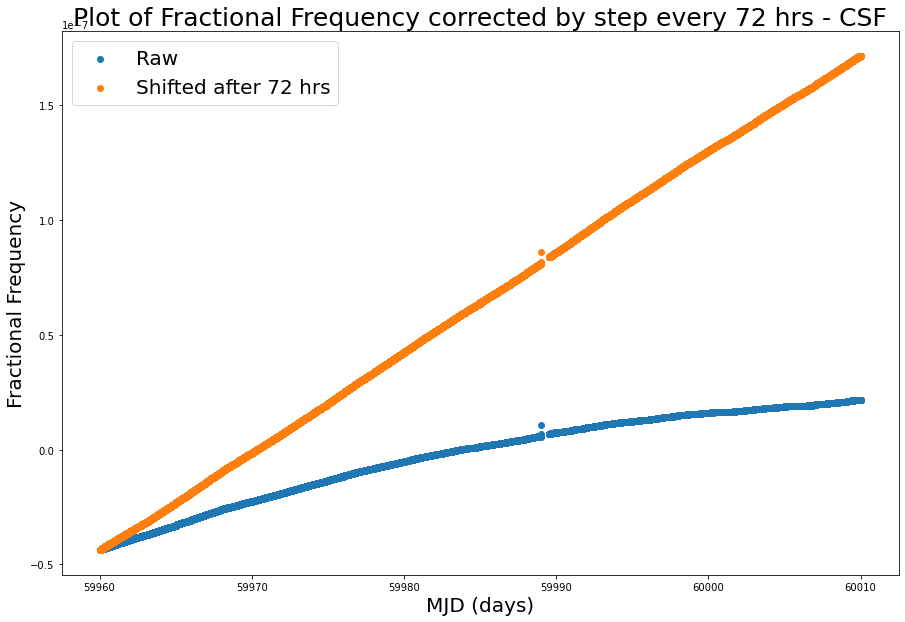

In [13]:
## Steered with 72 hour CSF steps

(F0_CSF_array72,steps72) = (CSF_Correction(np.arange(0,830,72),72))
steer_72hr = Steer_GPS_w_CSF(np.arange(0,50,3),np.arange(0,12,1),steps72)

plot_gps_steer(72,steer_72hr)

(<matplotlib.collections.PathCollection at 0x7fdac914d190>,
 <matplotlib.collections.PathCollection at 0x7fdac914d5b0>)

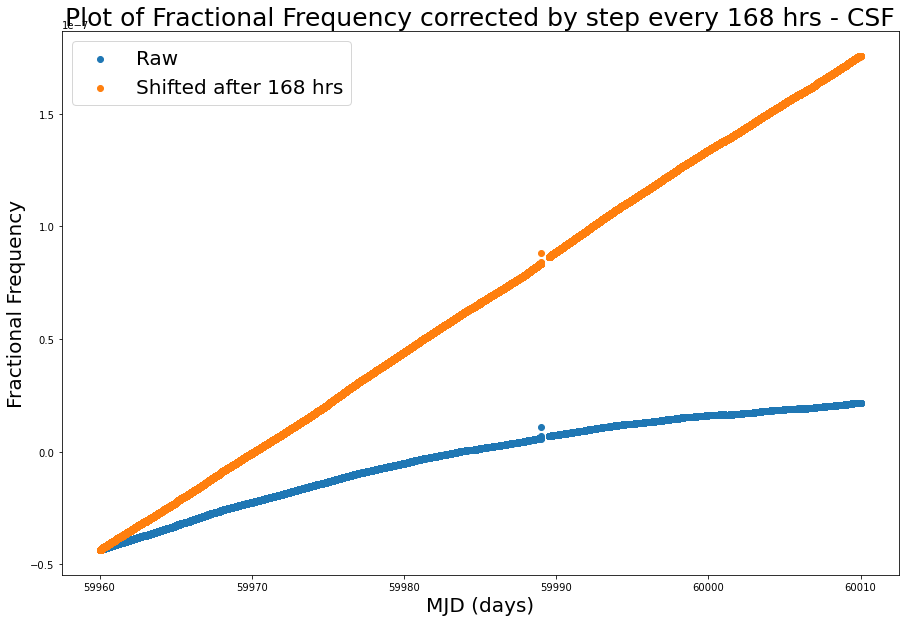

In [15]:
## Steered with 1 week CSF steps

(F0_CSF_array168,steps168) = (CSF_Correction(np.arange(0,750,168),168))
steer_week = Steer_GPS_w_CSF(np.arange(0,50,7),np.arange(0,5,1),steps168)

plot_gps_steer(168,steer_week)

## 1.3 Calculate and plot Allan Deviation

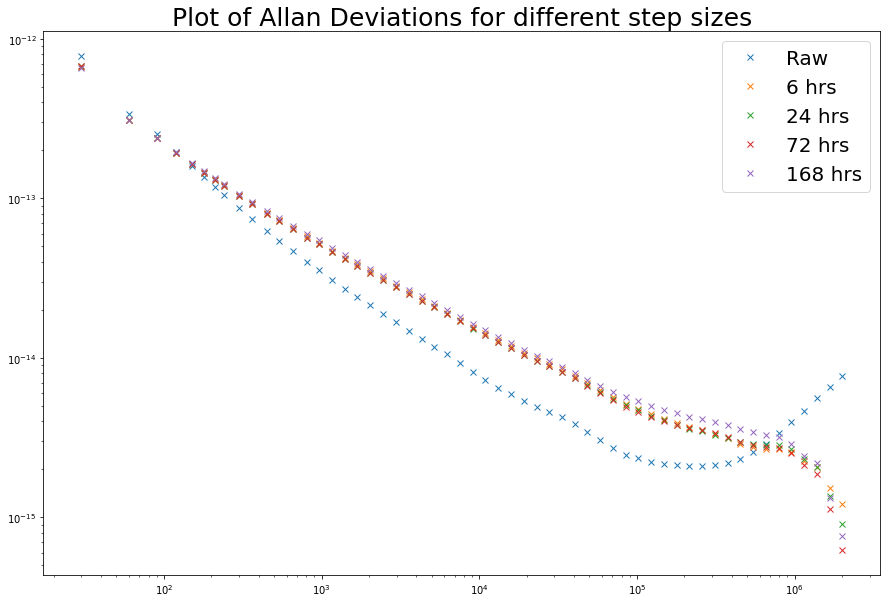

In [16]:
plt.figure(figsize=(15,10))

(t1, ad1, ade11, adn11) = at.oadev(np.array(Zoom_in_raw_GPS['diff_CLK(ns)']*1e-9), rate=1/30, data_type="phase",taus=np.logspace(0,8,100))
plt.loglog(t1,ad1,'x',label='Raw')

AD6_gps = Allan_Dev_time(steer_6hr,1/30,np.logspace(0,8,100),6)
AD24_gps = Allan_Dev_time(steer_24hr,1/30,np.logspace(0,8,100),24)
AD72_gps = Allan_Dev_time(steer_72hr,1/30,np.logspace(0,8,100),72)
AD168_gps = Allan_Dev_time(steer_week,1/30,np.logspace(0,8,100),168)

plt.title('Plot of Allan Deviations for different step sizes',fontsize=25)
plt.legend(fontsize=20)